In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/srfullsat/allhigh/low/616611_sat.jpg
/kaggle/input/srfullsat/allhigh/low/704062_sat.jpg
/kaggle/input/srfullsat/allhigh/low/871656_sat.jpg
/kaggle/input/srfullsat/allhigh/low/71993_sat.jpg
/kaggle/input/srfullsat/allhigh/low/846289_sat.jpg
/kaggle/input/srfullsat/allhigh/low/598497_sat.jpg
/kaggle/input/srfullsat/allhigh/low/268564_sat.jpg
/kaggle/input/srfullsat/allhigh/low/646682_sat.jpg
/kaggle/input/srfullsat/allhigh/low/942974_sat.jpg
/kaggle/input/srfullsat/allhigh/low/592996_sat.jpg
/kaggle/input/srfullsat/allhigh/low/794616_sat.jpg
/kaggle/input/srfullsat/allhigh/low/125002_sat.jpg
/kaggle/input/srfullsat/allhigh/low/77698_sat.jpg
/kaggle/input/srfullsat/allhigh/low/537301_sat.jpg
/kaggle/input/srfullsat/allhigh/low/716527_sat.jpg
/kaggle/input/srfullsat/allhigh/low/889820_sat.jpg
/kaggle/input/srfullsat/allhigh/low/751202_sat.jpg
/kaggle/input/srfullsat/allhigh/low/139947_sat.jpg
/kaggle/input/srfullsat/allhigh/low/576981_sat.jpg
/kaggle/input/srfullsat/allhigh/l

In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [3]:
from skimage.transform import resize, rescale
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
high_img = []
path = '/kaggle/input/srfullsat/allhigh/high'
files = os.listdir(path)
files = sorted_alphanumeric(files)
counthigh = 0
countlow = 0
#kernel_3x3 = np.ones((3, 3), np.float32) / 9 #boxblur
# We apply the filter and display the image
 
for i in tqdm(files):    
    if counthigh == 5000:
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))
        counthigh = counthigh + 1


low_img = []
path = '/kaggle/input/srfullsat/allhigh/low'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if countlow == 5000:
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE//2, SIZE//2))
        img = img.astype('float32') / 255.0
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE),interpolation = cv2.INTER_AREA)
        #img = cv2.filter2D(img, -1, kernel_3x3)
        
        low_img.append(img_to_array(img))
        countlow = countlow +1

 59%|█████▉    | 5000/8470 [02:38<01:50, 31.49it/s]


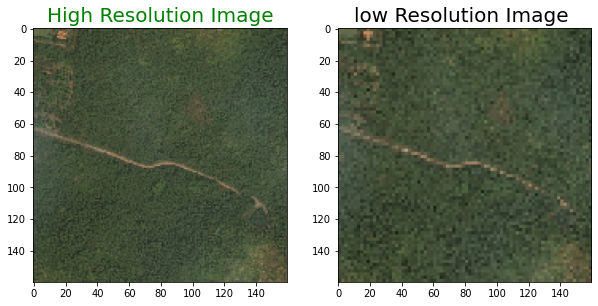

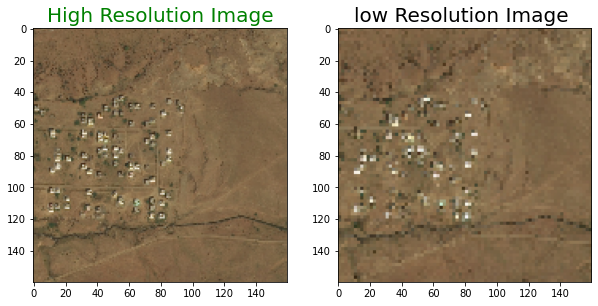

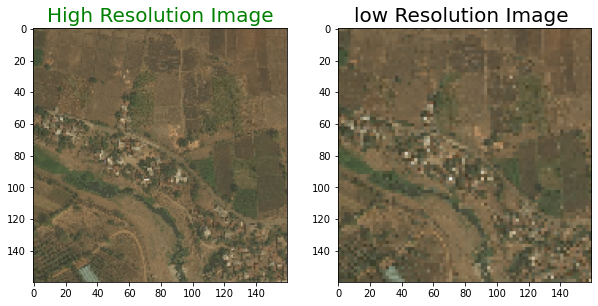

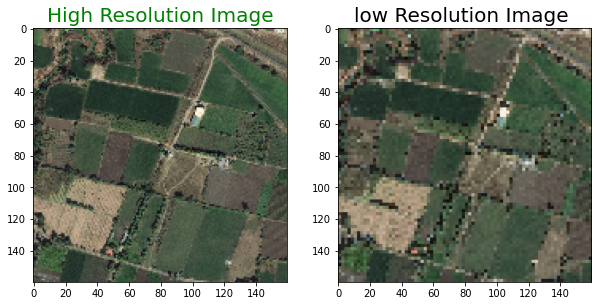

In [4]:
for i in range(4):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Image', color = 'green', fontsize = 20)
    plt.imshow(high_img[i])
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[i])

In [5]:
train_high_image = high_img[:4000]
train_low_image = low_img[:4000]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))


test_high_image = high_img[4000:]
test_low_image = low_img[4000:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))


In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 1))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 1))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 160, 160, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 160, 160, 128 147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 160, 160, 256 296192      sequential_1[0][0]               
______________________________________________________________________________________________

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])


In [8]:
model.fit(train_low_image, train_high_image, epochs = 3, batch_size = 1)

Epoch 1/3
4000/4000 [==============================] - 426s 105ms/step - loss: 0.0966 - acc: 0.7959
Epoch 2/3
4000/4000 [==============================] - 421s 105ms/step - loss: 0.0427 - acc: 0.8968
Epoch 3/3
4000/4000 [==============================] - 421s 105ms/step - loss: 0.1089 - acc: 0.8941


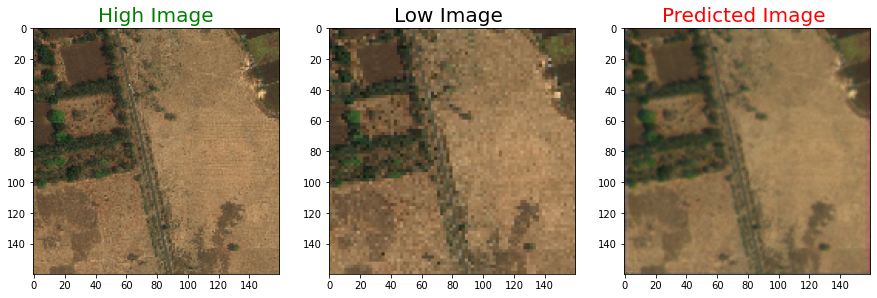

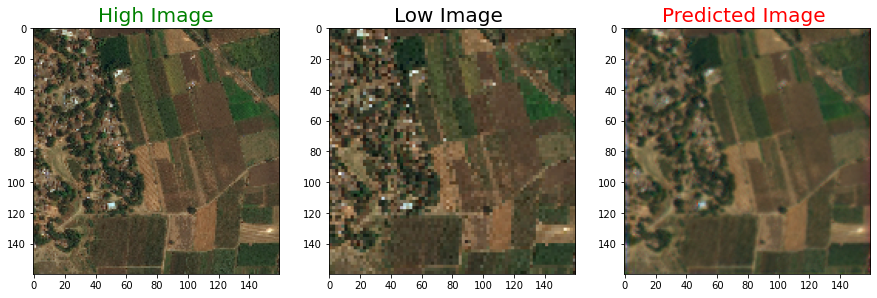

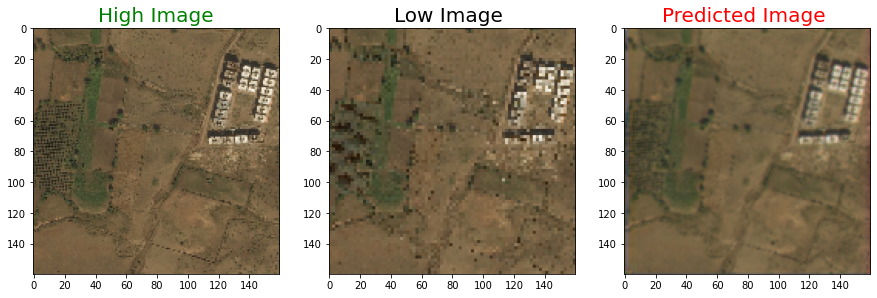

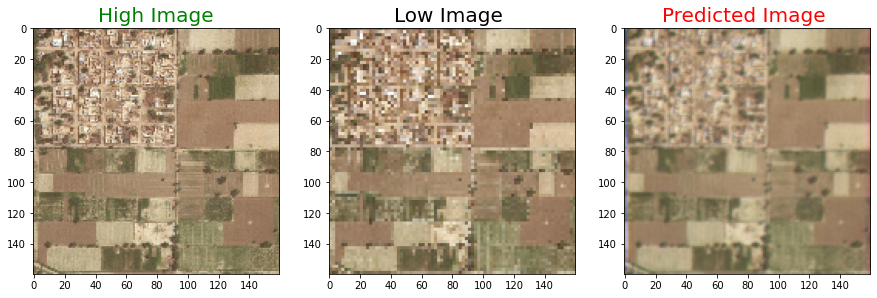

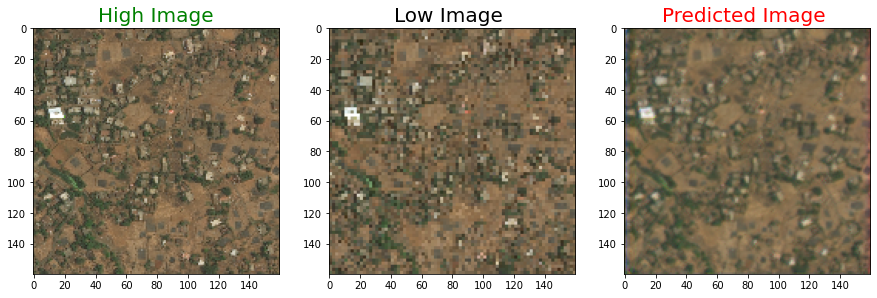

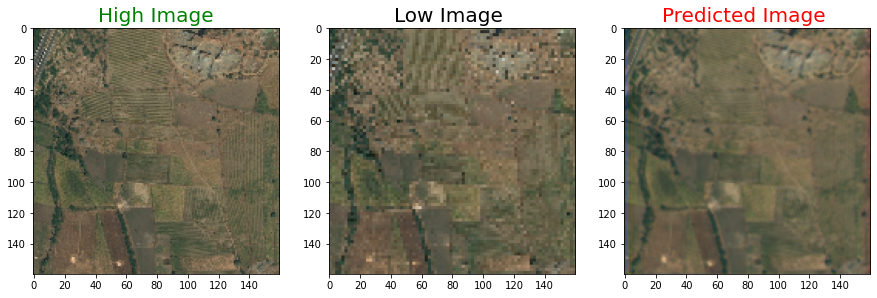

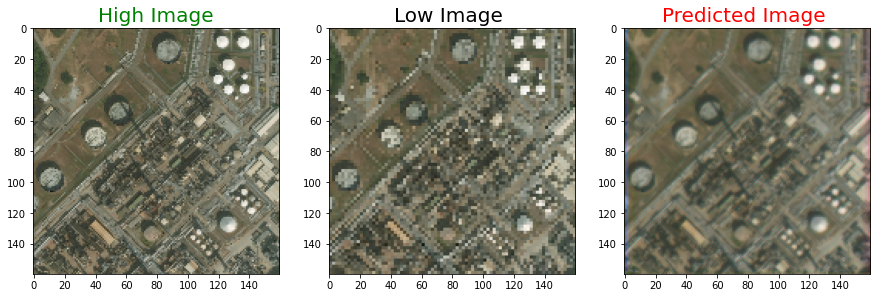

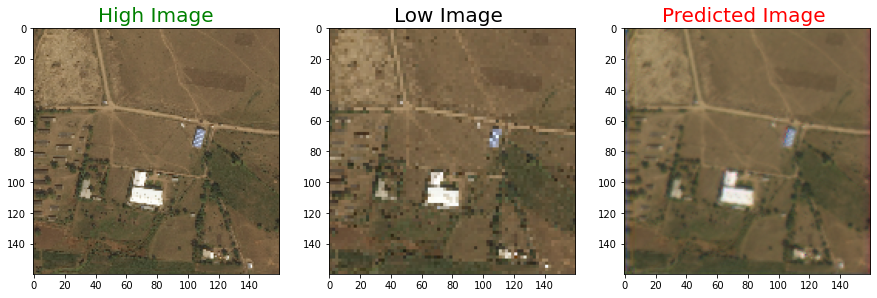

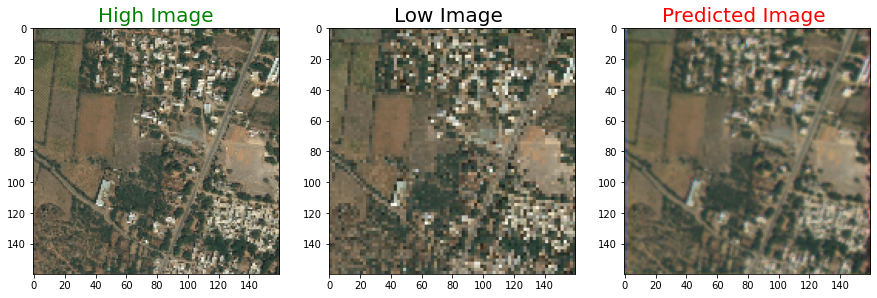

In [9]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    predicted = np.clip(model.predict(test_high_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [10]:
model.save("final_model.h5")